In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tvt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import pickle

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
def arrangeDataSIDD(file_path = './data/SIDD_Medium_Srgb/Data', train_ratio=0.8):

    print("Arranging the SIDD images")
    file_list = os.listdir(file_path)
    random.shuffle(file_list)
    training_data = {"noisy":[], "gt":[]}
    testing_data = {"noisy":[], "gt": []}
    index = int(len(file_list)*train_ratio)
    train_files = file_list[:index]
    test_files = file_list[index : ]

    print('Creating training data')
    for i in tqdm(range(len(train_files))):
        img_paths = os.path.join(file_path, train_files[i])
        img_lists = os.listdir(img_paths)
        for img in img_lists:
            if "GT_SRGB_010" in img:
                gt_img = Image.open(os.path.join(img_paths, img)).convert('RGB').resize((128,128))
                training_data['gt'].append(gt_img)
            if "NOISY_SRGB_010" in img:
                noisy_img = Image.open(os.path.join(img_paths, img)).convert('RGB').resize((128,128))
                training_data['noisy'].append(noisy_img)
    print("Number of ground truth images:",len(training_data['gt']))
    print("Number of noisy images:",len(training_data['noisy']))


    print('Creating testing data')
    for i in tqdm(range(len(test_files))):
        img_paths = os.path.join(file_path, test_files[i])
        img_lists = os.listdir(os.path.join(file_path, test_files[i]))
        for img in img_lists:
            if "GT_SRGB_010" in img:
                gt_img = Image.open(os.path.join(img_paths, img)).convert('RGB').resize((512,512))
                testing_data['gt'].append(gt_img)
            if "NOISY_SRGB_010" in img:
                noisy_img = Image.open(os.path.join(img_paths, img)).convert('RGB').resize((512,512))
                testing_data['noisy'].append(noisy_img)
    print("Number of ground truth images:",len(testing_data['gt']))
    print("Number of noisy images:",len(testing_data['noisy']))

    with open('./data_sidd.pkl','wb') as f:
        pickle.dump((training_data, testing_data), f, protocol=pickle.HIGHEST_PROTOCOL)
    print('Pickle File Created for SIDD Images')

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data):
        super(ImageDataset, self).__init__()
        self.noisyData = data['noisy']
        self.gtData = data['gt']
        self.transform = tvt.Compose([tvt.ToTensor()])

    def __len__(self):
        return len(self.noisyData)

    def __getitem__(self, index):
        return self.transform(self.noisyData[index]), self.transform(self.gtData[index])

In [4]:
def createDataLoaders():
    if not os.path.isfile('./data_sidd.pkl'):
        arrangeDataSIDD()
    with open('./data_sidd.pkl', 'rb') as f:
        data = pickle.load(f)
    train_dataset = ImageDataset(data[0])
    test_dataset = ImageDataset(data[1])
    train_DL = DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=False)
    test_DL = DataLoader(test_dataset, batch_size=16, num_workers=2, shuffle=False)
    return train_DL, test_DL, train_dataset, test_dataset

In [5]:
class dCNN(torch.nn.Module):
    def __init__(self, channels, layers=20):
        super(dCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=channels, out_channels=64, kernel_size=3, padding=1, bias=False
        )
        self.convList = torch.nn.ModuleList()
        for i in range(layers - 2):
            self.convList.append(
                torch.nn.Conv2d(
                    in_channels=64,
                    out_channels=64,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                )
            )
            self.convList.append(torch.nn.BatchNorm2d(64))
            self.convList.append(torch.nn.ReLU(inplace=True))
        self.conv2 = torch.nn.Conv2d(
            in_channels=64, out_channels=channels, kernel_size=3, padding=1, bias=False
        )

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x, inplace=True)
        for conv in self.convList:
            x = conv(x)
        x = self.conv2(x)
        return x

In [6]:
# function to check PSNR(dB)/SSIM values of the resulted images
def calculate_metrics(image, original, data_range):
    image = image.data.cpu().numpy().astype(np.float32)
    original = original.data.cpu().numpy().astype(np.float32)
    psnr_value = 0
    ssim_value = 0
    for i in range(image.shape[0]):
        psnr_value += psnr(
            original[i, :, :, :], image[i, :, :, :], data_range=data_range
        )
        ssim_value += ssim(
            original[i, :, :, :],
            image[i, :, :, :],
            channel_axis=0,
            data_range=data_range,
        )
    psnr_value /= image.shape[0]
    ssim_value /= image.shape[0]

    return psnr_value, ssim_value

In [7]:
def trainingR2R(model, device, dataloader, epochs, min_sigma, max_sigma):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    criterion = torch.nn.MSELoss()
    alpha = 2
    losses = []
    psnr_values = []
    ssim_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        psnr_value = 0.0
        ssim_value = 0.0
        for idx, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            noisy_image, clean_image = data
            noisy_image = noisy_image.to(device)
            clean_image = clean_image.to(device)
            sigma = np.random.uniform(min_sigma/255.0, max_sigma/255.0)
            D = (sigma/255.00) * torch.FloatTensor(noisy_image.size()).normal_(mean=0, std=1.0).cuda()
            input = noisy_image + alpha * D
            target = noisy_image - D / alpha
            output = torch.clamp(model(input),0,1)
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # evaluating the performance per batch
            model.eval()
            input = noisy_image
            output = torch.clamp(model(input), 0, 1)
            psnr_val, ssim_val = calculate_metrics(output, clean_image, 1.0)
            psnr_value += psnr_val
            ssim_value += ssim_val
            if idx != 0 and (idx+1) % 4 == 0:
                losses.append((running_loss / 4))
                psnr_values.append((psnr_value / 4))
                ssim_values.append((ssim_value/4))
                print(
                    "Epoch:",epoch + 1,
                    "[",idx + 1,"|",
                    len(dataloader),"]",
                    "=>",
                    "PSNR:",psnr_value / 4,
                    "SSIM",ssim_value / 4,
                    "Loss:",running_loss / 4,
                )
                running_loss = 0.0
                psnr_value = 0.0
                ssim_value = 0.0

            del noisy_image
            del clean_image
            del input
            del output

    # creating a plot and saving it
    fig, axes = plt.subplots(3,1)
    fig.tight_layout()
    axes[0].plot(losses)
    axes[0].title.set_text("R2R Training Loss")

    axes[1].plot(psnr_values)
    axes[1].title.set_text("R2R Training PSNR Values")

    axes[2].plot(ssim_values)
    axes[2].title.set_text("R2R Training SSIM Values")
    
    fig.savefig("./"+"R2R_SIDD_TrainingResult.png")

    file_name = "./" + "R2R_SIDD" + "_model_" + str(min_sigma) + "_" + str(max_sigma) + ".pth"
    torch.save(model.state_dict(), file_name)

In [8]:
def trainingN2N(model, device, dataloader, epochs, min_sigma, max_sigma):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    criterion = torch.nn.MSELoss()
    losses = []
    psnr_values = []
    ssim_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        psnr_value = 0.0
        ssim_value = 0.0
        for idx, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            noisy_image, clean_image = data
            noisy_image = noisy_image.to(device)
            clean_image = clean_image.to(device)
            std1 = np.random.uniform(min_sigma/255.0, max_sigma/255.0)
            std2 = np.random.uniform(min_sigma/255.0, max_sigma/255.0)
            input = clean_image + (torch.FloatTensor(noisy_image.size()).normal_(mean=0)*std1).cuda()
            target = clean_image + (torch.FloatTensor(noisy_image.size()).normal_(mean=0)*std2).cuda()
            output = torch.clamp(model(input),0,1)
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # evaluating the performance per batch
            model.eval()
            input = noisy_image
            output = torch.clamp(model(input), 0, 1)
            psnr_val, ssim_value = calculate_metrics(output, clean_image, 1.0)
            psnr_value += psnr_val
            if idx != 0 and (idx+1) % 4 == 0:
                losses.append((running_loss / 4))
                psnr_values.append((psnr_value / 4))
                ssim_values.append((ssim_value/4))
                print(
                    "Epoch:",epoch + 1,
                    "[",idx + 1,"|",
                    len(dataloader),"]",
                    "=>",
                    "PSNR:",psnr_value / 4,
                    "SSIM",ssim_value / 4,
                    "Loss:",running_loss / 4,
                )
                running_loss = 0.0
                psnr_value = 0.0
                ssim_value = 0.0

            del noisy_image
            del clean_image
            del input
            del output

    # creating a plot and saving it
    fig, axes = plt.subplots(3,1)
    fig.tight_layout()
    axes[0].plot(losses)
    axes[0].title.set_text("N2N Training Loss")

    axes[1].plot(psnr_values)
    axes[1].title.set_text("N2N Training PSNR Values")

    axes[2].plot(ssim_values)
    axes[2].title.set_text("N2N Training SSIM Values")
    
    fig.savefig("./"+"N2N_SIDD_TrainingResult.png")
    file_name = "./" + "N2N_SIDD" + "_model_" + str(min_sigma) + "_" + str(max_sigma) + ".pth"
    torch.save(model.state_dict(), file_name)

In [9]:
def trainingN2C(model, device, dataloader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    criterion = torch.nn.MSELoss()
    losses = []
    psnr_values = []
    ssim_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        psnr_value = 0.0
        ssim_value = 0.0
        for idx, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            noisy_image, clean_image = data
            noisy_image = noisy_image.to(device)
            clean_image = clean_image.to(device)
            input = noisy_image
            target = clean_image
            output = torch.clamp(model(input),0,1)
            loss = criterion(output, target) 
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # evaluating the performance per batch
            model.eval()
            output = torch.clamp(model(noisy_image), 0, 1)
            psnr_val, ssim_value = calculate_metrics(output, clean_image, 1.0)
            psnr_value += psnr_val
            if idx != 0 and (idx+1) % 4 == 0:
                losses.append((running_loss / 4))
                psnr_values.append((psnr_value / 4))
                ssim_values.append((ssim_value/4))
                print(
                    "Epoch:",epoch + 1,
                    "[",idx + 1,"|",
                    len(dataloader),"]",
                    "=>",
                    "PSNR:",psnr_value / 4,
                    "SSIM",ssim_value / 4,
                    "Loss:",running_loss / 4,
                )
                running_loss = 0.0
                psnr_value = 0.0
                ssim_value = 0.0

            del noisy_image
            del clean_image
            del output

    # creating a plot and saving it
    fig, axes = plt.subplots(3,1)
    fig.tight_layout()

    axes[0].plot(losses)
    axes[0].title.set_text("N2C Training Loss")

    axes[1].plot(psnr_values)
    axes[1].title.set_text("N2C Training PSNR Values")

    axes[2].plot(ssim_values)
    axes[2].title.set_text("N2C Training SSIM Values")

    fig.savefig("./"+"N2C_SIDD_TrainingResult.png")
    file_name = "./" + "N2C_SIDD" + "_model_" + ".pth"
    torch.save(model.state_dict(), file_name)

In [59]:
def testAlgorithms(model, dataset, model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    psnr_list = []
    ssim_list = []
    test_output = None
    for i in range(len(dataset)):
        noisy_image, clean_image = dataset[i]
        input = torch.unsqueeze(noisy_image, 0).to(device)
        target = torch.unsqueeze(clean_image, 0).to(device)
        with torch.no_grad():
            output = model(input)
        out = torch.clamp(output, 0, 1)
        psnr_val, ssim_value = calculate_metrics(out, target, data_range=1.0)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_value)
        del output
    print(
        "PSNR of testing dataset:",
        sum(psnr_list) / len(psnr_list),
        "SSIM of testing dataset:",
        sum(ssim_list) / len(ssim_list),
    )

In [87]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)

def histogram_comparison(clean_image, denoised_image):
    # tuple to select colors of each channel line
    colors = ("red", "green", "blue")

    clean_image = np.array(clean_image)
    denoised_image = np.array(denoised_image)

    fig, ax = plt.subplots(1,2, figsize=(25,10))
    ax[0].set_xlim([0, 256])
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            denoised_image[:, :, channel_id], bins=256, range=(0, 256)
        )
        ax[0].plot(bin_edges[0:-1], histogram, color=color)

    ax[0].set_title("R2R Denoised", fontsize=20)
    ax[0].set_xlabel("Color value", fontsize=20)
    ax[0].set_ylabel("Pixel count", fontsize=20)

    ax[1].set_xlim([0,256])
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            clean_image[:, :, channel_id], bins=256, range=(0, 256)
        )
        ax[1].plot(bin_edges[0:-1], histogram, color=color)

    ax[1].set_title("Clean Image", fontsize=20)
    ax[1].set_xlabel("Color value", fontsize=20)
    ax[1].set_ylabel("Pixel count", fontsize=20)

def sampleTesting(dataset, R2R_model, R2R_model_path, N2C_model, N2C_model_path, N2N_model, N2N_model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    R2R_model.load_state_dict(torch.load(R2R_model_path))
    N2C_model.load_state_dict(torch.load(N2C_model_path))
    N2N_model.load_state_dict(torch.load(N2N_model_path))
    R2R_model.eval()
    N2C_model.eval()
    N2N_model.eval()
    idx = random.randint(0, len(dataset))
    noisy_image, clean_image = dataset[idx]
    noisy_image = noisy_image.to(device)
    clean_image = clean_image.to(device)
    input = torch.unsqueeze(noisy_image, 0).to(device)
    target = torch.unsqueeze(clean_image, 0).to(device)
    with torch.no_grad():
        R2R_output = R2R_model(input)
        N2C_output = N2C_model(input)
        N2N_output = N2N_model(input)
    R2R_out = torch.clamp(R2R_output, 0, 1)
    N2C_out = torch.clamp(N2C_output, 0, 1)
    N2N_out = torch.clamp(N2N_output, 0, 1)
    psnr_val_R2R, ssim_value_R2R = calculate_metrics(R2R_out, target, data_range=1.0)
    psnr_val_N2C, ssim_value_N2C = calculate_metrics(N2C_out, target, data_range=1.0)
    psnr_val_N2N, ssim_value_N2N = calculate_metrics(N2N_out, target, data_range=1.0)
    fig,axes = plt.subplots(1,5, figsize=(50,10))
    #fig.tight_layout()
    noisy_PIL = tvt.ToPILImage()(noisy_image.squeeze().cpu())
    clean_PIL = tvt.ToPILImage()(clean_image.squeeze().cpu())
    R2R_out_PIL = tvt.ToPILImage()(R2R_out.squeeze().cpu())
    N2N_out_PIL = tvt.ToPILImage()(N2N_out.squeeze().cpu())
    N2C_out_PIL = tvt.ToPILImage()(N2C_out.squeeze().cpu())
    axes[1].imshow(noisy_PIL)
    axes[1].set_title("Noisy Image", size=50)
    axes[0].imshow(clean_PIL)
    axes[0].set_title("Clean Image", size=50)
    axes[2].imshow(R2R_out_PIL)
    axes[2].set_title("R2R", size=50)
    axes[3].imshow(N2C_out_PIL)
    axes[3].set_title("N2C", size=50)
    axes[4].imshow(N2N_out_PIL)
    axes[4].set_title("N2N", size=50)
    format_axes(fig)

    histogram_comparison(clean_PIL, R2R_out_PIL)

In [12]:
# Main Pipeline using SIDD Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainDL, testDL, trainDataset, testDataset = createDataLoaders()
model_R2R = dCNN(channels=3)
#model_R2R_50 = dCNN(channels=3)
model_N2N = dCNN(channels=3)
model_N2C = dCNN(channels=3)

Epoch: 1 [ 4 | 8 ] => PSNR: 10.763632558988212 SSIM 0.2123528400552459 Loss: 0.0535720270127058
Epoch: 1 [ 8 | 8 ] => PSNR: 8.680827355625004 SSIM 0.25817122403532267 Loss: 0.042531510815024376
Epoch: 2 [ 4 | 8 ] => PSNR: 9.603531563249557 SSIM 0.19271995162125677 Loss: 0.02974566211923957
Epoch: 2 [ 8 | 8 ] => PSNR: 8.674983174972056 SSIM 0.198946415563114 Loss: 0.028408305253833532
Epoch: 3 [ 4 | 8 ] => PSNR: 10.013206455005886 SSIM 0.1903445937205106 Loss: 0.024302947334945202
Epoch: 3 [ 8 | 8 ] => PSNR: 10.63969643675811 SSIM 0.22025657165795565 Loss: 0.026471149176359177
Epoch: 4 [ 4 | 8 ] => PSNR: 14.87162943232129 SSIM 0.3296856500674039 Loss: 0.02315855585038662
Epoch: 4 [ 8 | 8 ] => PSNR: 14.471910658402159 SSIM 0.3433898059884086 Loss: 0.02448214218020439
Epoch: 5 [ 4 | 8 ] => PSNR: 16.645540814221874 SSIM 0.37447081762365997 Loss: 0.020252935122698545
Epoch: 5 [ 8 | 8 ] => PSNR: 17.133358861721316 SSIM 0.423169176094234 Loss: 0.021458048839122057
Epoch: 6 [ 4 | 8 ] => PSNR: 

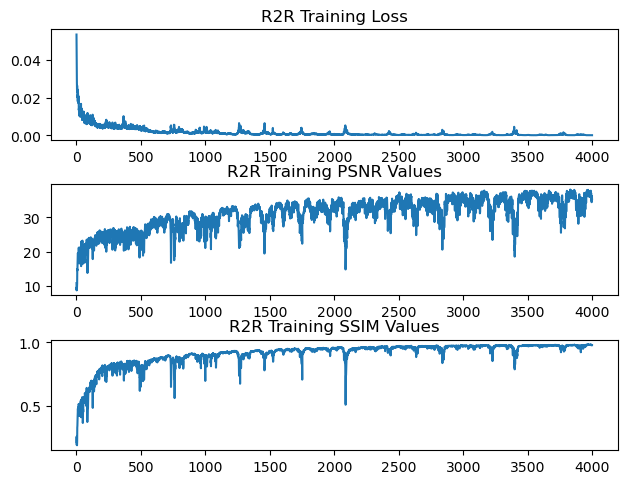

In [13]:
trainingR2R(model_R2R, device, trainDL, 2000, 25, 50)

In [14]:
#trainingR2R(model_R2R_50, device, trainDL, 1000, 50)  # training the model with sigma = 50

Epoch: 1 [ 4 | 8 ] => PSNR: 10.810643347554496 SSIM 0.03141723439330235 Loss: 0.0722409076988697
Epoch: 1 [ 8 | 8 ] => PSNR: 7.4526831393943676 SSIM 0.04473915428388864 Loss: 0.05631265789270401
Epoch: 2 [ 4 | 8 ] => PSNR: 7.266654807683391 SSIM 0.02654049068223685 Loss: 0.041447448544204235
Epoch: 2 [ 8 | 8 ] => PSNR: 6.8406137681163255 SSIM 0.04196769103873521 Loss: 0.05029813013970852
Epoch: 3 [ 4 | 8 ] => PSNR: 8.086247213614033 SSIM 0.036048769776243716 Loss: 0.043317148461937904
Epoch: 3 [ 8 | 8 ] => PSNR: 11.862080832600935 SSIM 0.04717513651121408 Loss: 0.04618446249514818
Epoch: 4 [ 4 | 8 ] => PSNR: 13.504767689743051 SSIM 0.026514010649407282 Loss: 0.03929790109395981
Epoch: 4 [ 8 | 8 ] => PSNR: 13.388023886321767 SSIM 0.04780122602824122 Loss: 0.04463437758386135
Epoch: 5 [ 4 | 8 ] => PSNR: 14.284811316718026 SSIM 0.03836317308014259 Loss: 0.042448109947144985
Epoch: 5 [ 8 | 8 ] => PSNR: 13.924698173701227 SSIM 0.058024541358463466 Loss: 0.05073976144194603
Epoch: 6 [ 4 | 8 

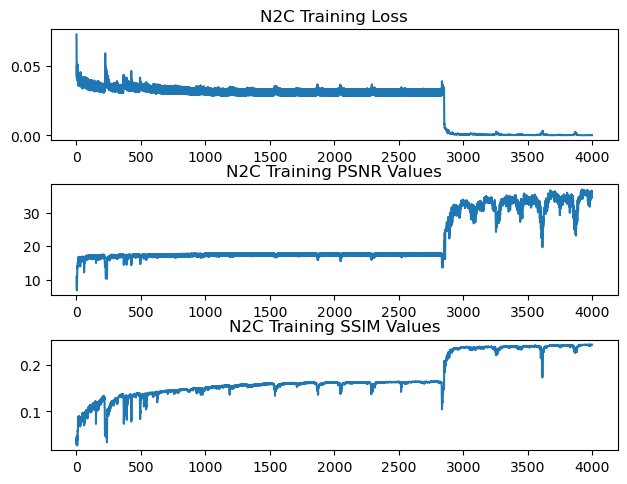

In [15]:
trainingN2C(model_N2C, device, trainDL, 2000)

Epoch: 1 [ 4 | 8 ] => PSNR: 8.916213860355587 SSIM 0.0436955412151292 Loss: 0.08692059479653835
Epoch: 1 [ 8 | 8 ] => PSNR: 5.412789521254245 SSIM 0.07021129876375198 Loss: 0.08387367986142635
Epoch: 2 [ 4 | 8 ] => PSNR: 8.73652805374204 SSIM 0.059458852163515985 Loss: 0.06568805407732725
Epoch: 2 [ 8 | 8 ] => PSNR: 9.547753362339455 SSIM 0.06751031917519867 Loss: 0.07731602899730206
Epoch: 3 [ 4 | 8 ] => PSNR: 11.549673144209459 SSIM 0.0393569270381704 Loss: 0.07110337074846029
Epoch: 3 [ 8 | 8 ] => PSNR: 11.999980863668325 SSIM 0.04142284789122641 Loss: 0.07026786636561155
Epoch: 4 [ 4 | 8 ] => PSNR: 13.511683421960374 SSIM 0.032643761369399726 Loss: 0.0685863783583045
Epoch: 4 [ 8 | 8 ] => PSNR: 13.077661108659232 SSIM 0.050687399809248745 Loss: 0.06711934600025415
Epoch: 5 [ 4 | 8 ] => PSNR: 14.841449300361603 SSIM 0.06918608327396214 Loss: 0.06440915632992983
Epoch: 5 [ 8 | 8 ] => PSNR: 14.63208213921669 SSIM 0.07418383611366153 Loss: 0.06400854606181383
Epoch: 6 [ 4 | 8 ] => PSNR

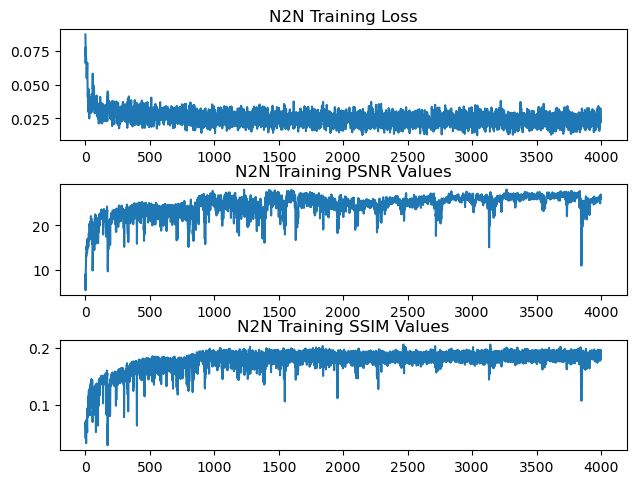

In [16]:
trainingN2N(model_N2N, device, trainDL, 2000, 25, 50)

In [60]:
testAlgorithms(model_R2R, testDataset, "./R2R_SIDD_model_25_50.pth")

PSNR of testing dataset: 34.31245214188899 SSIM of testing dataset: 0.9244863297790289


In [61]:
testAlgorithms(model_N2N, testDataset, "./N2N_SIDD_model_25_50.pth")

PSNR of testing dataset: 26.243904012883366 SSIM of testing dataset: 0.8152597174048424


In [62]:
testAlgorithms(model_N2C, testDataset, "./N2C_SIDD_model_.pth")

PSNR of testing dataset: 34.3813379881405 SSIM of testing dataset: 0.9456962458789349


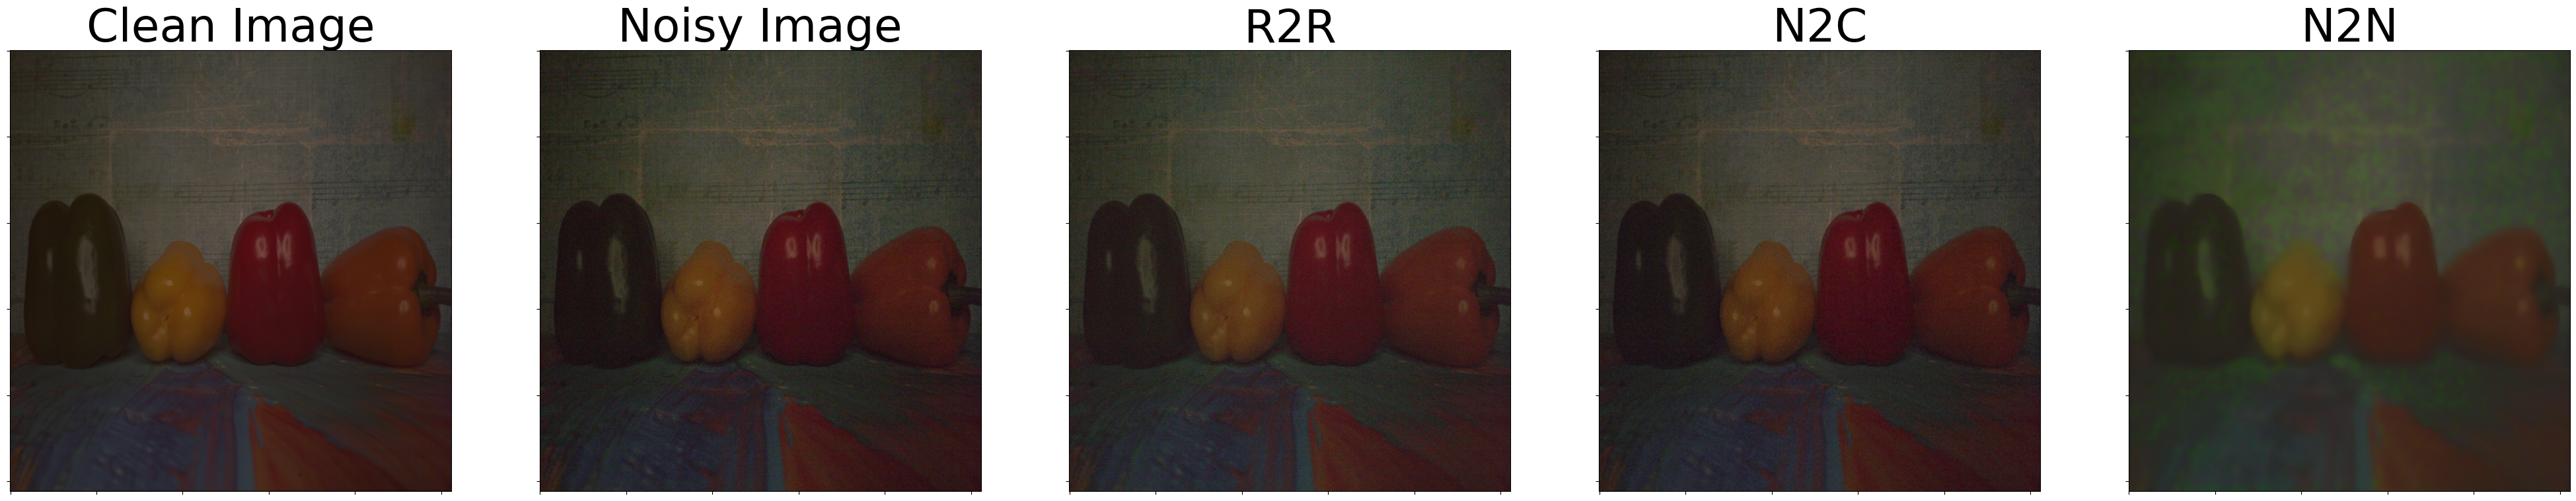

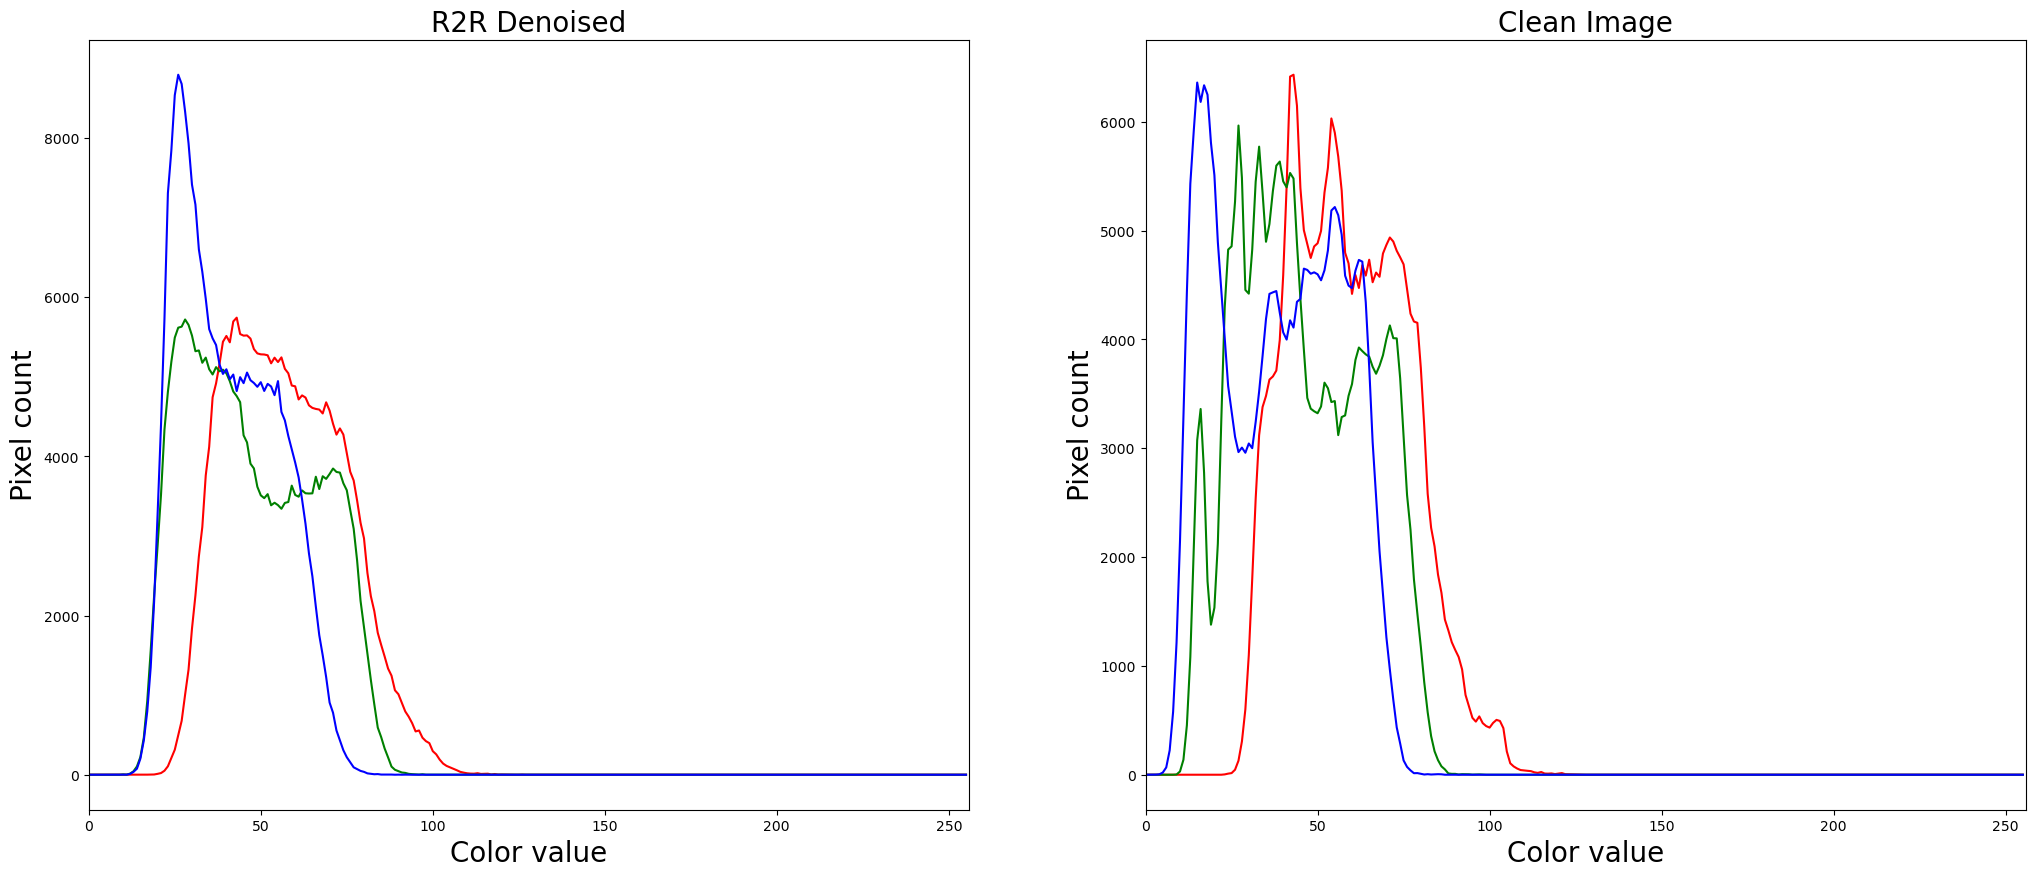

In [94]:
sampleTesting(testDataset, model_R2R,  "./R2R_SIDD_model_25_50.pth",  model_N2C, "./N2C_SIDD_model_.pth", model_N2N, "./N2N_SIDD_model_25_50.pth")